# Self-contained Example - Coupled nonlinear oscillators on Fashion MNIST

In this notebook, we show how a physical neural network can be constructed out of coupled nonlinear oscillators to perform the Fashion MNIST task. The main goals of this notebook is to have a self-contained jupyter notebook that walks through the following key steps involved in training a physical neural network via physics aware training.  

- Defining a parametrized input-output map for both the physical and the differential digital model
- Constructing the custom autograd function necessary for PAT
- Constructing and train a physical neural network with the custom PAT function at hand
- Load the trained model and visualize the results


For this example, we consider a physical neural network based on coupled nonlinear oscillators. Here we consider an all-to-all connected coupled nonlinear oscillators that obeys the following equations of motion. 

$$ \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin{q_i} + \sum_{j=1}^N J_{ij}\left( \sin{q_j} - \sin{q_i} \right) +e_i $$ 
where $q_i$ are the oscillator amplitudes, $J_{ij}$ are the coupling coefficients (which must be symmetric, i.e., $J_{ij}=J_{ji}$), and $e_i$ are individual oscillator drives. 

The oscillator system is turned into a PNN by the following input-output map. We encode the data into the initial amplitudes, and the output is taken to be state of the oscillator after some time-evolution.  Because this is a second order ODE, the first derivatives are set to 0, so the system begins at rest $\dot q_i (t=0) = 0$. Finally, the trainable parameters of the PNN are the coupling constants between the oscillators, $J_{ij}$, i.e., $\vec{\theta} = [J_{11}, J_{12}, ..., J_{NN}]$.

We model the noise present in setting the initial oscillator amplities in an experiment via $q_i(t=0) = x_i + n_i$, where $n_i$ is sampled from a normal distribution of 2\% standard deviation.

In order to simulate the effect of the mismatch between model and experiment that is addressed by physics-aware training, we add noise to (a) the nonlinearity coefficient, and (b) the coupling coefficients J_ij. Thus, while the model remains described by the equation above, the physical system is described by:
$$    \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin({(1+\eta)q_i}) + \sum_{j=1}^N (J_{ij}+J^{\mathrm{noise}}_{ij})\left( \sin({(1+\eta)q_j}) - \sin({(1+\eta) q_i}) \right) +e_i $$

Because capturing locality of the image data present in the Fashion MNIST data is important, we consider the following PNN architecture. Here each 28x28 image is divided into 16 patches of 49pixels each. Each patch is then processed by a **small, 100 oscillator network**. These output are all combined later all concatenated into a 1600 oscillator vector, which is then processed a **larger, 1610 oscillator network**. 

To begin, the notebook will now define the input-output maps associated with both the small and large oscillator networks that are generated from the differential equations above. 

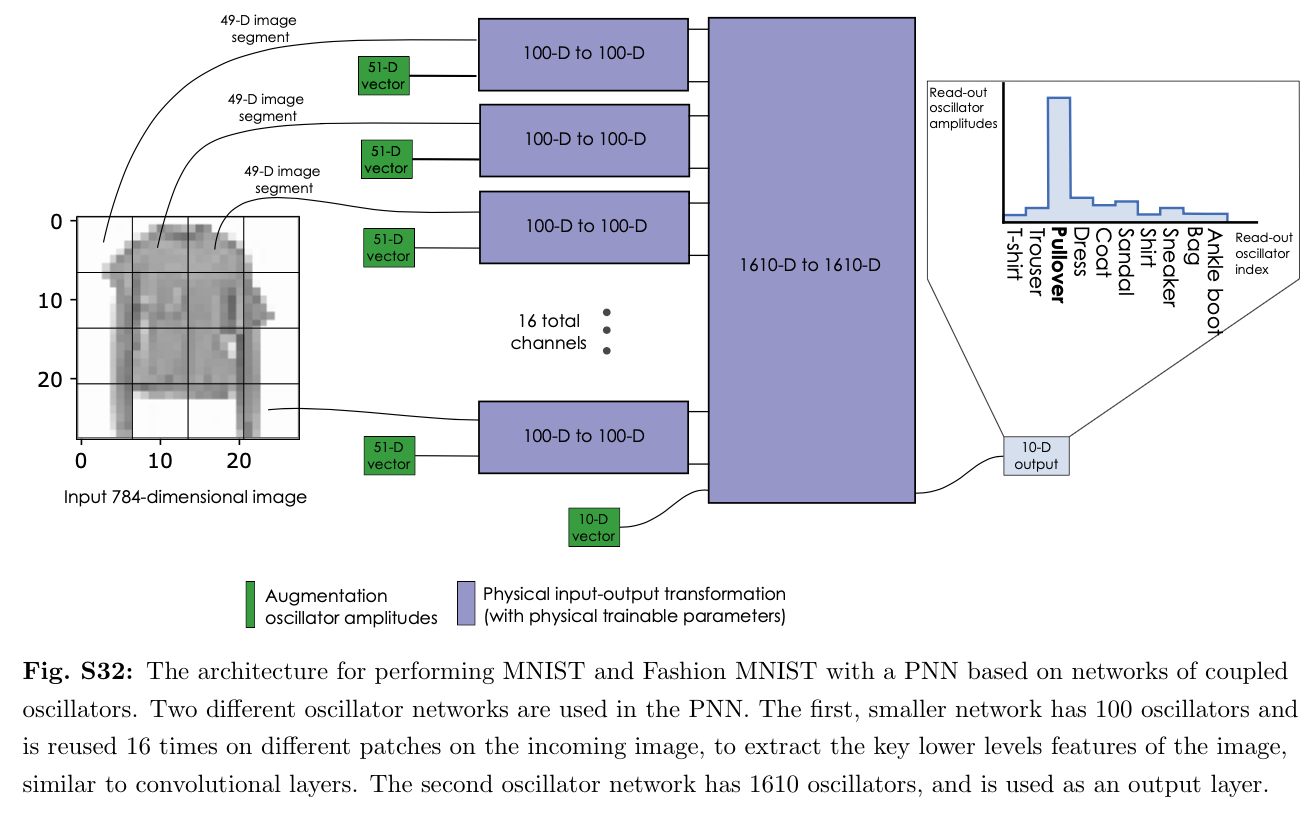

## Defining the input-output maps

To speed up the computation, define a new matrix $Q$ such that the offdiagonal elements of $Q$ are that of $J$ and the diagonal elements are given by $Q_{ii} = -\sum_j J_{ij}$. Using this matrix, the equations of motion can be simplified into a matrix multiplication as follows:

$$ \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin{q_i} + \sum_{j=1}^N Q_{ij}\sin{q_j} +e_i $$ 

In [1]:
#A function to convert from J to Q. Also ensures that Q is symmetric
def J2Q(J):
    Q = (J + J.T)/2
    Jcolsum = -torch.sum(Q, axis=0)
    inds = list(range(J.shape[0]))
    Q[inds, inds] = Jcolsum
    return Q

#Define the ODE for the model with this Qmatrix
#Note this ODE can be used as a model for both the small and large oscillator network
def ode_model(z, Q, e):
    q = z[..., 0]
    p = z[..., 1]
    output = torch.empty_like(z)
    output[..., 0] = p
    sin_q = torch.sin(q)
    output[..., 1] = -sin_q + e + sin_q@Q
    return  output

In [2]:
import torch

device = 0 #gpu number, use "cpu" if running on CPU

#parameters associated with the architecture
image_size = 28
patch_size = 7
dim = 100
num_patches = (image_size // patch_size) ** 2

#parameters associated with the model experiment mismatch
noise = 0.2
η = 0.1

# Define the noise coupling matrices
torch.manual_seed(0)
Q_small_noise = J2Q(noise*torch.randn(dim, dim)).to(device)
Q_large_noise = J2Q(noise*torch.randn(dim*num_patches+10, dim*num_patches+10)).to(device)

In [3]:
#Define the ODE for the small oscillator network
def ode_exp_small(z, Q, e):
    with torch.no_grad(): #to emulate an experiment - make sure that physical function cannot be backpropped through
        q = z[..., 0]
        p = z[..., 1]
        output = torch.empty_like(z)
        output[..., 0] = p
        sin_q = torch.sin((1+η)*q)
        output[..., 1] = -sin_q + e + sin_q@Q + sin_q@Q_small_noise
    return  output

#Define the ODE for the large oscillator network
def ode_exp_large(z, Q, e):
    with torch.no_grad():
        q = z[..., 0]
        p = z[..., 1]
        output = torch.empty_like(z)
        output[..., 0] = p
        sin_q = torch.sin((1+η)*q)
        output[..., 1] = -sin_q + e + sin_q@Q + sin_q@Q_large_noise
    return  output

With the ODE specified, we solve them via the RK4 ODE solver defined below

In [4]:
#parameters associated with the ODE solver
Nt = 5 #checked that 5 points converges - (same classification accuracy is achieved)
T = 0.5 #how long the ODE is time-evolved for
dt = T/Nt #discretization step for the ODE solver

#Generate code for solving ODEs with RK4
def rk_loop(ode, x, h, *args):
    k1 = ode(x, *args)
    k2 = ode(x+h*k1/2, *args)
    k3 = ode(x+h*k2/2, *args)
    k4 = ode(x+h*k3, *args)
    return x + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

#This function takes the ODE function and loops over in time to return the final output
def make_ode_map(ode):
    def ode_map(x, *args):
        for i in range(Nt):
            x = rk_loop(ode, x, dt, *args)
        return x  
    return ode_map #returns the function

#This function takes a given ode_map and constructs the PNN function!
#Thus, for this example, it would be responsible for constructing the 
def make_io_map(f_Q):
    def f_J(x, J, e):
        Q = J2Q(J)
        return f_Q(x, Q, e)
    return f_J

ode_map_model = make_ode_map(ode_model)
ode_map_exp_small = make_ode_map(ode_exp_small)
ode_map_exp_large = make_ode_map(ode_exp_large)

With the ode_maps, we can now define the input output map of the physical model and the differential digital model for both the small and large networks

In [5]:
#function to generate the input noise of setting the initial oscillator amplitudes
def make_noise(x):
    n_tensor = torch.zeros_like(x)
    n_tensor[..., 0] = 0.02*torch.randn(x.shape[:-1])
    return n_tensor

#The differential digital model for the parameterized input output map of the small oscillator network 
def f_model_small(x, J, e):
    Q = J2Q(J)    
    x = torch.stack([x, torch.zeros_like(x)], dim=-1) #adding the dot q = 0 augmentation
    x = torch.cat([x, torch.zeros([*x.shape[:-2], dim-patch_size**2, 2] #augmenting 49 dimension to 100 dimension
                                  , device=x.device)], dim=-2)
    x += make_noise(x)
    x = ode_map_model(x, Q, e)
    x = x[..., 0]
    return x
        
#The parameterized physical input output map of the small oscillator network 
def f_exp_small(x, J, e):
    Q = J2Q(J)    
    x = torch.stack([x, torch.zeros_like(x)], dim=-1) #adding the dot q = 0 augmentation
    x = torch.cat([x, torch.zeros([*x.shape[:-2], dim-patch_size**2, 2] #augmenting 49 dimension to 100 dimension
                                  , device=x.device)], dim=-2)
    x += make_noise(x)
    x = ode_map_exp_small(x, Q, e)
    x = x[..., 0]
    return x

#The differential digital model for the parameterized input output map of the large oscillator network 
def f_model_large(x, J, e):
    Q = J2Q(J)    
    x = torch.stack([x, torch.zeros_like(x)], dim=2)
    x = torch.cat([x, torch.zeros([x.shape[0], 10, 2], device=x.device)], dim=1)

    x += make_noise(x)
    x = ode_map_model(x, Q, e)
    x = x[:, -10:, 0] #return the last class oscillator
    return x

#The parameterized physical input output map of the large oscillator network 
def f_exp_large(x, J, e):
    Q = J2Q(J)    
    x = torch.stack([x, torch.zeros_like(x)], dim=2)
    x = torch.cat([x, torch.zeros([x.shape[0], 10, 2], device=x.device)], dim=1)

    x += make_noise(x)
    x = ode_map_exp_large(x, Q, e)
    x = x[:, -10:, 0] #return the last class oscillator
    return x

## Creating the custom PAT autograd function

In [6]:
#General code that returns the PAT autograd function given the forward and backward pass function
def generate_func(forward_f, backward_f):
    class func(torch.autograd.Function):
        @staticmethod
        def forward(ctx, *args): 
            ctx.save_for_backward(*args)
            return forward_f(*args)
        def backward(ctx, grad_output):
            args = ctx.saved_tensors
            torch.set_grad_enabled(True)
            y = torch.autograd.functional.vjp(backward_f, args, v=grad_output)
            torch.set_grad_enabled(False)
            return y[1]
    return func.apply

f_pat_small = generate_func(f_exp_small, f_model_small)
f_pat_large = generate_func(f_exp_large, f_model_large)

## Constructing and train a physical neural network 

### Load fashion MNIST dataset

In [7]:
## Vanilla code for loading the Fashion MNIST dataset
batch_size = 32
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
compress_factor = 1
reshape_f = lambda x: torch.reshape(x[0, ::compress_factor, ::compress_factor], (-1, ))
transform = transforms.Compose([transforms.ToTensor()])

transform_noise = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor()])

transform_val = transforms.Compose([transforms.ToTensor()])

train_set = (FashionMNIST(
    root = '../..',
    train = True,
    download = True,
    transform = transform_noise
))

val_set = (FashionMNIST(
    root = '../..',
    train = False,
    download = True,
    transform = transform_val
))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

/usr/local/anaconda/envs/NN_v2/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


'T-shirt'

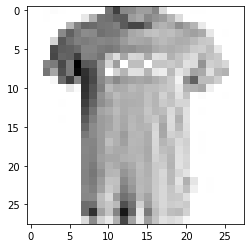

In [8]:
#Visualize one instance of the dataset
import matplotlib.pyplot as plt
torch.manual_seed(0)
x, y = next(iter(train_loader))

labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", 
          "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

ind = 3

plt.imshow(x[ind].reshape(28, 28), cmap="binary")

labels[y[ind]]

### Defining the PNN architecture and training the PNN

To define the pytorch module as well as the train a given model to perform the Fashion MNIST task, we uses the [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) package. This package effectively allows us performs the full training loop with minimal code, in addition to performing the logging of the training and the optimal model.

**Important**: Pytorch-lightning is a rapidly evolving package, thus it is very important to be operating with the correct version of it. To make sure that the correct version is installed, install (or reinstall) the package with the following command line command. 

```pip install pytorch-lightning==0.9.0```. 

In [9]:
import pytorch_lightning as pl

if pl.__version__ != '0.9.0':
    print("Warning! The version of pytorch-lightning that you have installed is not 0.9.0. Please see installation instructions above")

### Defining the PNN architecture in pytorch

In [10]:
from pytorch_lightning.metrics import Accuracy
from einops.layers.torch import Rearrange, Reduce
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class PNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', 
                              p1 = patch_size, p2 = patch_size)
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim*num_patches+10, dim*num_patches+10)
        self.output_fac = nn.Parameter(torch.tensor(1.0).float())
        self.accu_metric = Accuracy()
        
    def forward(self, x):
        x = self.rearrange(x) #this converts the [Nbatch, 1, 28, 28] tensor to the tensor with the 16 patches of 49-dimensional vectors with shape [Nbatch, 16, 49] 
        x = f_pat_small(x, *self.fc1.parameters()) #Because of broadcasting, this simple line of code is really running the 16 uses of the small oscillator in parallel!
        x = x.view(x.shape[0], -1) #flatten the vector
        x = f_pat_large(x, *self.fc2.parameters()) #Use the large oscillator network to obtain a 10-dimensional vector 
        x = self.output_fac*x
        return x
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters())
        return optimizer
    
    #The following code defines the how the training loop will be performed by pytorch-lightning
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = F.cross_entropy(out, y) 
        y_pred = torch.max(out, 1)[1]
        accuracy = self.accu_metric(y_pred, y)

        result = pl.TrainResult(loss)
        result.log('train_loss', torch.sqrt(loss))
        result.log('train_accu', accuracy)
        return result
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = F.cross_entropy(out, y) 
        y_pred = torch.max(out, 1)[1]
        accuracy = self.accu_metric(y_pred, y)

        result = pl.EvalResult(checkpoint_on=accuracy)
        result.log('val_loss', loss)
        result.log('val_accu', accuracy)
        return result

In [11]:
model = PNN().to(device)

In [12]:
#check that the module does run
x, y = next(iter(train_loader))
model(x.to(device)).shape

torch.Size([32, 10])

### Training configuration
The training for this model takes about 90 minutes on a GPU. If the user wants the skip the training and load the trained model - please skip these cells and run the cells in the next section.

In [ ]:
#defines where the training curve is saved + where the model is saved
import os 
log_dir = "precomputed_results"
logger = pl.loggers.CSVLogger(log_dir, "Example4", "trial4")

max_epochs = 30

In [81]:
checkpoint_file = os.path.join(log_dir, "Example4", "trial4", "{epoch}-{val_accu:.2f}")
checkpoint_cb = pl.callbacks.ModelCheckpoint(checkpoint_file, mode="max")

In [82]:
if device != "cpu":
    trainer = pl.Trainer(max_epochs=max_epochs, logger=logger, gpus=[device],
                            log_save_interval=50, row_log_interval=4, val_check_interval=0.2,
                            checkpoint_callback=checkpoint_cb, 
                            weights_summary=None, progress_bar_refresh_rate=0)
else:
    trainer = pl.Trainer(max_epochs=max_epochs, logger=logger,
                            log_save_interval=50, row_log_interval=4, val_check_interval=0.2,
                            checkpoint_callback=checkpoint_cb, 
                            weights_summary=None, progress_bar_refresh_rate=0)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [83]:
trainer.fit(model, train_loader, val_loader)

/usr/local/anaconda/envs/NN_v2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Experiment logs directory precomputed_results/Example4/trial4 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
/usr/local/anaconda/envs/NN_v2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/usr/local/anaconda/envs/NN_v2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 112 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/usr/loca

1

## Visualize results

### Load the training cuve and the trained parameters

In [14]:
import os
import glob
#load the parameters of the model
data_dir = "precomputed_results/Example3/trial3"

ckpt = glob.glob(os.path.join(data_dir,'*.ckpt'))[0]

if device != "cpu":
    save_dict = torch.load(ckpt, map_location=f"cuda:{device}")
else: 
    save_dict = torch.load(ckpt, map_location="cpu")
state_dict = save_dict["state_dict"]
state_dict.keys()

model = PNN().to(device)

model.load_state_dict(state_dict)

<All keys matched successfully>

### Plot the trained coupling matrices and internal dynamics present in the oscillator network

Text(0.5, 1.0, '$e_{i}$ of first oscillator network')

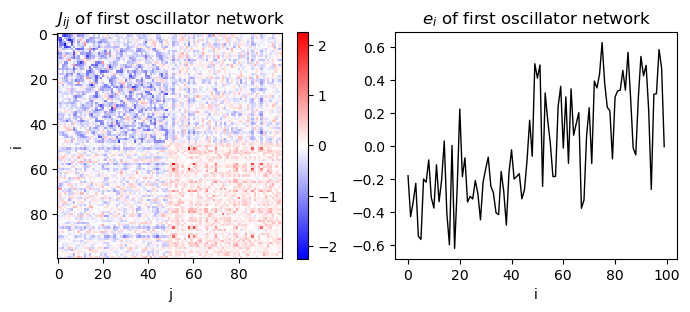

In [17]:
Q_small = J2Q(state_dict["fc1.weight"])
e_small = state_dict["fc1.bias"]

Q = Q_small
e = e_small
Q_offdiag = Q.clone()

for i in range(Q_offdiag.shape[0]):
    Q_offdiag[i,i]=0.0
Q_small_offdiag = Q_offdiag.clone()

fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=100)

plt.sca(axs[0])
vmax = torch.max(torch.abs(Q_offdiag)).cpu()
plt.imshow((Q_offdiag.cpu()), vmax=vmax, vmin=-vmax, cmap="bwr", interpolation="nearest")
plt.colorbar()
plt.ylabel("i")
plt.xlabel("j")
plt.title(r"$J_{ij}$ of first oscillator network")

plt.sca(axs[1])
plt.plot(e.cpu(), "k", lw=1)
plt.xlabel("i")
plt.title(r"$e_{i}$ of first oscillator network")

Text(0.5, 1.0, '$e_{i}$ of second oscillator network')

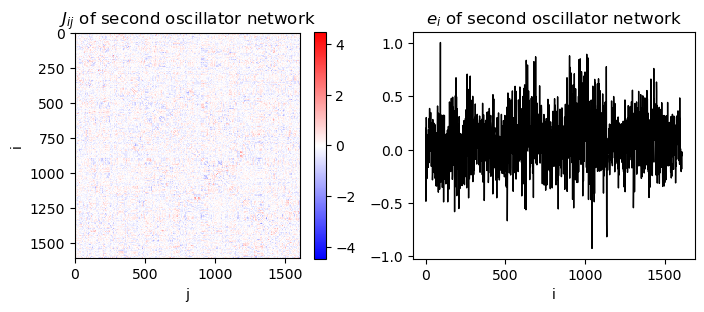

In [19]:
Q_large = J2Q(state_dict["fc2.weight"])
e_large = state_dict["fc2.bias"]

Q = Q_large
e = e_large
Q_offdiag = Q.clone()
Q_large_offdiag = Q_offdiag.clone()

for i in range(Q_offdiag.shape[0]):
    Q_offdiag[i,i]=0.0

fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=100)

plt.sca(axs[0])
vmax = torch.max(torch.abs(Q_offdiag)).cpu()
plt.imshow((Q_offdiag).cpu(), vmax=vmax, vmin=-vmax, cmap="bwr", interpolation="nearest")
plt.colorbar()
plt.ylabel("i")
plt.xlabel("j")
plt.title(r"$J_{ij}$ of second oscillator network")

plt.sca(axs[1])
plt.plot(e.cpu(), "k", lw=1)
plt.xlabel("i")
plt.title(r"$e_{i}$ of second oscillator network")

In [20]:
Nt = 100
tend = 0.5
dt = tend/Nt

0 T-shirt


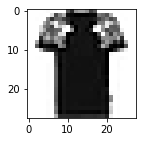

In [29]:
import numpy as np
import matplotlib.cm as cm

torch.manual_seed(4)
x, y = next(iter(val_loader))

plt.figure(figsize=(2,2))
ind = 4
img = x[ind, :].numpy()
target = y[ind].numpy()
print(target, labels[target])

plt.imshow(img[0], cmap="binary");


self = model.to(device)
x = x.to(device)

x = self.rearrange(x)
x = torch.stack([x, torch.zeros_like(x)], dim=-1)
x = torch.cat([x, torch.zeros([*x.shape[:-2], dim-patch_size**2, 2]
                              , device=x.device)], dim=-2)
x += make_noise(x)

tlist = np.linspace(0, tend, Nt)
xlist = torch.empty([Nt, *x.shape])

with torch.no_grad():
    for i in range(Nt):
        x = rk_loop(ode_exp_small, x, dt, Q_small, e_small)
        xlist[i] = x

x = x[..., 0]
x = x.view(x.size(0), -1)

x = torch.stack([x, torch.zeros_like(x)], dim=2)
x = torch.cat([x, torch.zeros([x.shape[0], 10, 2], device=x.device)], dim=1)
x += make_noise(x)

tlist = np.linspace(0, tend, Nt)
xlist = torch.empty([Nt, *x.shape])

with torch.no_grad():
    for i in range(Nt):
        x = rk_loop(ode_exp_large, x, dt, Q_large, e_large)
        xlist[i] = x

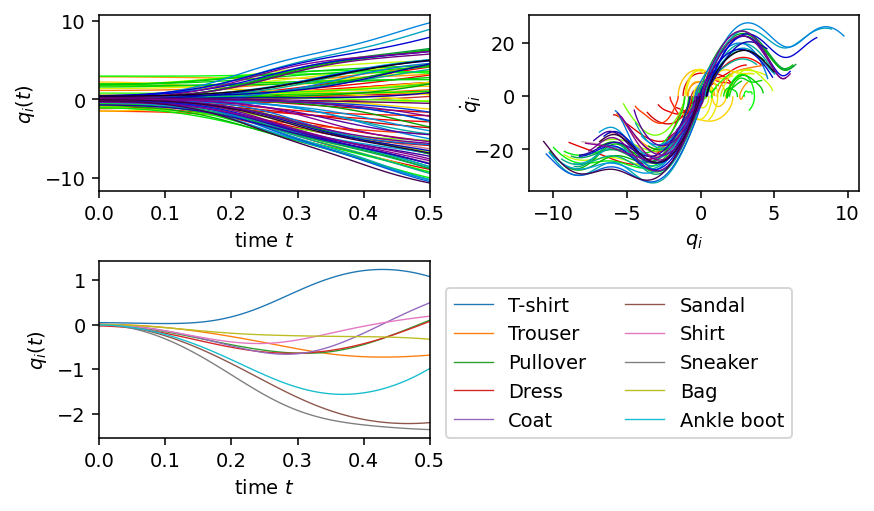

In [30]:
# cmap = cm.gist_rainbow_r
cmap = cm.nipy_spectral_r

fig, axs = plt.subplots(2, 2, figsize=(7, 4), dpi=140)

fig.subplots_adjust(hspace=0.4, wspace=0.3)
for osc_ind in range(100):
    q = [x[ind, osc_ind, 0] for x in xlist]
    p = [x[ind, osc_ind, 1] for x in xlist]
    
    plt.sca(axs[0,0])
    plt.plot(tlist, q, color=cmap(osc_ind/100), lw=0.7)
    plt.xlabel(r"time $t$")
    plt.ylabel(r"$q_i(t)$")
    plt.xlim(0, 0.5)
    
    plt.sca(axs[0,1])
    plt.plot(q, p, color=cmap(osc_ind/100), lw=0.7)
    plt.ylabel(r"$\dot q_i$", labelpad=-5)
    plt.xlabel(r"$q_i$")

cmap = cm.tab10

plt.sca(axs[1,0])
for (i, traj) in enumerate(xlist[:, ind, -10:, 0].T):
    plt.plot(tlist, traj, color=cmap(i/10), label=f"{labels[i]}", lw=0.7)
plt.legend(loc=(1.05, 0.0), ncol=2)
plt.xlabel(r"time $t$")
plt.ylabel(r"$q_i(t)$")
plt.xlim(0, 0.5)

plt.sca(axs[1,1])
plt.axis("off");

### Plot the training curve and confusion matrix

In [23]:
#load the training curve
import pandas as pd
df = pd.read_csv(os.path.join(data_dir, "metrics.csv"))
mask = [not(x) for x in np.isnan(df["val_accu"].values)]
epoch = df["epoch"].values[mask]
accu = df["val_accu"].values[mask]
epoch = epoch[::5]
accu = accu[::5]

In [24]:
#The following are plotting utility functions to make the plots in the supplementary material
#Not necessary, can use simpler plotting code if desired
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics as metrics
from itertools import product
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

class ConfusionMatrixDisplay:
    #porting and editting code from scipy's ConfusionMatrixDisplay
    def __init__(self, confusion_matrix, display_labels):
        self.confusion_matrix = confusion_matrix
        self.display_labels = display_labels
    def plot(self, include_values=True, cmap='viridis',
             xticks_rotation='horizontal', values_format=None, ax=None, fontsize=10):
        import matplotlib.pyplot as plt
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure
        cm = self.confusion_matrix
        n_classes = cm.shape[0]
        self.im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        self.text_ = None
        cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(256)
        if include_values:
            self.text_ = np.empty_like(cm, dtype=object)
            if values_format is None:
                values_format = '.2g'
            # print text with appropriate color depending on background
            for i, j in product(range(n_classes), range(n_classes)):
                self.text_[i, j] = ax.text(j, i,
                                           format(cm[i, j], values_format),
                                           ha="center", va="center",
                                           color="k", fontsize=fontsize)
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=self.display_labels,
               yticklabels=self.display_labels,
               ylabel="True label",
               xlabel="Predicted label")
        ax.set_ylim((n_classes - 0.5, -0.5))
        plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)
        self.figure_ = fig
        self.ax_ = ax
        return self

color_pat = np.array([17, 74, 189])/255
white = [1, 1, 1] #rgb values for white
marker_pat = "o"

def plot_dots_v2(x, y, marker, color, **kwargs):
    color_f = make_rgb_transparent(color, white, 0.3)
    plt.plot(x, y, "--", marker=marker, mec=color, mfc=color_f, markersize=5, markeredgewidth=0.7, lw=0.5, color=color, **kwargs)

def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

In [25]:
#the following code runs the trained model on examples from the validation set
#to construct a confusion matrix
torch.manual_seed(0)
x = []
y = []
for xi, yi in list(val_loader):
    x.append(xi)
    y.append(yi)

x = torch.cat(x, dim = 0).to(device)
print(x.shape)
target = torch.cat(y, dim = 0)

with torch.no_grad():
    out = model(x)

pred = torch.max(out, 1)[1].cpu()

Ndig = 100
target_eq=list()
pred_eq=list()
count = np.zeros(10)
for idx in range(len(pred)):
    ti=target[idx]
    yi=pred[idx]
    count[ti]+=1
    if count[ti]<=Ndig:
        target_eq.append(ti)
        pred_eq.append(yi)
conf = metrics.confusion_matrix(target_eq, pred_eq);

torch.Size([10000, 1, 28, 28])


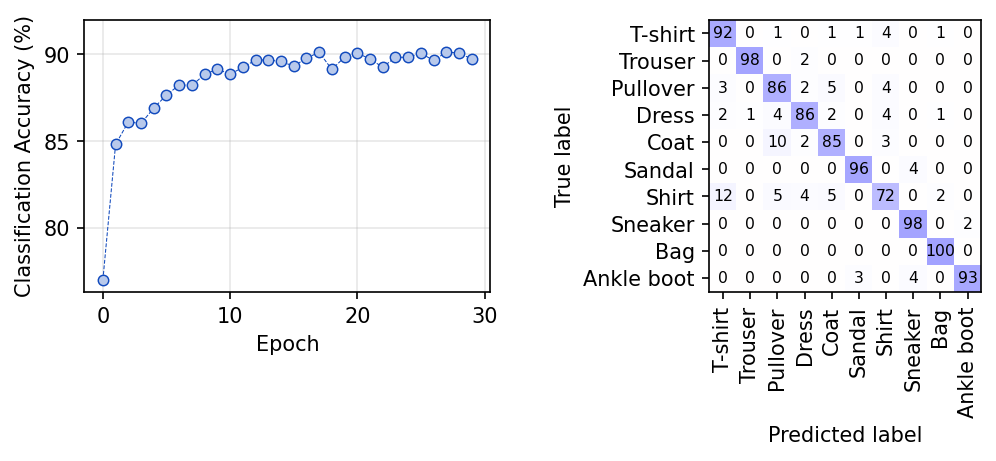

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.4), 
                    gridspec_kw=dict(width_ratios=[0.6, 0.5]), dpi=150)

fig.subplots_adjust(wspace=0.5)
plt.sca(axs[0])
plot_dots_v2(epoch, accu*100, marker_pat, color_pat, label="Physics-Aware Training")
plt.grid(alpha=0.3)
plt.ylim(top=92)

plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy (%)")

plt.sca(axs[1])
cmap = cm.get_cmap('bwr', 512)
custom_cmap = ListedColormap(cmap(np.linspace(0.5, 0.32, 256)))
disp = ConfusionMatrixDisplay(conf, labels)
size = 1
disp.plot(cmap=custom_cmap, ax=plt.gca(), values_format="d", fontsize=7.5, xticks_rotation='vertical')